**TMA4320: Prosjekt i Fysikk - Jo Andersson Stokka, Jonas Armonas**

In [1]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
from numba import jit
"""Solver"""

@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x


"""Constants"""
L = 100 #meter, L er dybde på konveksjonssonen
K0 = 10E-3 #meter^2/sekund
Ka = 2*10E-2 #meter^2/sekund
Kb = 5*10E-2 #meter^2/sekund
za = 7 #meter
zb = 10 #meter
kw = 6.97E-5 #m/s, masstransfer koefficient med antatt konstant vindfart = 10m/s
N = 1000 #romlige oppdelinger
M = 10000 #oppdelinger i tid

def moleToPpm(a): #Gjør om mol av "a" til ppm i havet
    watermole = 1/(18.02E-6) #antall molekyler vann i 1 kubikkmeter
    ratio = a/watermole
    return ratio*10**6


Lager Matrisene R og L, som representerer den andre diskrete deriverte skrevet i endelig differanse for alle verdiene for z. I tillegg legges grensebetingelsene. "Gamma" representerer fluxen i overflaten z=0 eller index 0,0 i R og L matisen, og havbunden har fluxen 0.

In [2]:
def makeRL(K,z,dz,dt):
    """Shorthands"""
    alpha = dt/(2*dz**2)
    K_list = np.array([K(z[i]) for i in range(N+1)])
    Gamma = 2*alpha*kw*dz*(1-(K_list[1]-K_list[0])/(2*K_list[0]))
    Kmark = K_list[2:]-K_list[0:N-1]
    
    """L"""
    L_upper = -alpha*K_list[:-1] #-alpha/4*Kmark
    L_upper[0] *= 2
    L_middle = 1 + 2*alpha*K_list #+Gamma på første
    L_middle[0] +=Gamma
    L_lower = -alpha*K_list[1:] #+alpha/4*Kmark
    L_lower[-1] *=2
   
    """R"""
    R_upper = alpha*K_list[:-1] #+alpha/4*Kmark
    R_upper[0] *= 2
    R_middle = 1 - 2*alpha*K_list #-Gamma på første
    R_middle[0] -=Gamma
    R_lower = alpha*K_list[1:] #-alpha/4*Kmark
    R_lower[-1] *=2
    
    for i in range(N):#ordner #-alpha/4*Kmark leddet i L_upper og L_lower
        if i == 0:
            L_lower[i] += alpha/4*Kmark[i]
            R_lower[i] -= alpha/4*Kmark[i]
            continue
        if i == N-1:
            L_upper[i] -= alpha/4*Kmark[i-1]
            R_upper[i] += alpha/4*Kmark[i-1]
            continue
        else:  
            L_upper[i] -= alpha/4*Kmark[i-1]
            L_lower[i] += alpha/4*Kmark[i]
            R_upper[i] += alpha/4*Kmark[i-1]
            R_lower[i] -= alpha/4*Kmark[i]
            
    L = diags([L_upper, L_middle, L_lower], offsets = [1, 0, -1])
    R = diags([R_upper, R_middle, R_lower], offsets = [1, 0, -1])
    return L,R,Gamma

Funksjon som løser den partielle ikke-lineære differensialligningen med R og L

In [3]:

"""Iteration through time"""

def EulersStoreBror(C_eq,IC,K,days,z,dz):
    sek = days*24*3600 #konverterer til sekunder for at enheter skal ha homogenitet
    t,dt = np.linspace(0,sek,M,retstep=True)
    L,R,Gamma = makeRL(K,z,dz,dt)
    C = np.zeros((M,N+1)) #Konstruerer en tom matrise med som skal fylles med tid
    C[0] = IC
    Si1 = np.zeros(N+1)
    Si1 = Si1.transpose()
    Si2 = Si1
    max_C = np.zeros(M)
    min_C = np.zeros(M)
    max_C[0] = max(C[0])
    min_C[0] = min(C[0])
    for i in range(M-1):
        Si1[0] = 2*Gamma*C_eq[i]
        Si2[0] = 2*Gamma*C_eq[i+1]
        V = R@C[i] +0.5*(Si1 +Si2)
        C[i+1] = tdma(L,V)
        max_C[i+1] = max(C[i+1])
        min_C[i+1] = min(C[i+1])
    return C,t,max_C,min_C


**Oppgave 1**

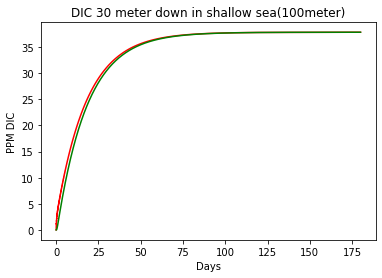

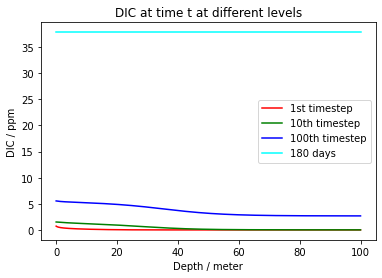

In [4]:


def K1(z): #Funksjonen som representerer fluksen gjennom planet som ligger z-meter under overflaten
    return K0 +Ka*z/za*np.exp(-z/za)+Kb*(L-z)*np.exp(-(L-z)/zb)/zb 
z,dz = np.linspace(0,100,N+1,retstep=True)
C_eq_val1 = 5060*415E-6 #mole/m^3
C_eq_vec1 = np.full((M),C_eq_val1)
IC1 = np.zeros(N+1) #initialconditions i oppgave 1
results1,times1,maximum1,minimum1 = EulersStoreBror(C_eq_vec1,IC1,K1,180,z,dz)

plt.figure(0)
plt.title("DIC 30 meter down in shallow sea(100meter)")
plt.xlabel("Days")
plt.ylabel("PPM DIC")
# plt.plot(times1/(3600*24),moleToPpm(results1[:,int(N*3/10)])) #times1/(3600*24) er tid skalert til tid i dager og N*3//10=30 meter
plt.plot(times1/(3600*24),moleToPpm(maximum1),"r",linestyle="-")
plt.plot(times1/(3600*24),moleToPpm(minimum1),"g",linestyle="-")
plt.figure(1)
plt.title("DIC at time t at different levels")
plt.xlabel("Depth / meter")
plt.ylabel("DIC / ppm")
z,dz = np.linspace(0,L,N+1,retstep=True)
plt.plot(z,moleToPpm(results1[1]),"r",linestyle="-")
plt.plot(z,moleToPpm(results1[10]),"g",linestyle="-")
plt.plot(z,moleToPpm(results1[100]),"b",linestyle="-")
plt.plot(z,moleToPpm(results1[-1]),"aqua",linestyle="-")
plt.legend(("1st timestep","10th timestep","100th timestep","180 days"))
plt.show()

**Oppgave 2**

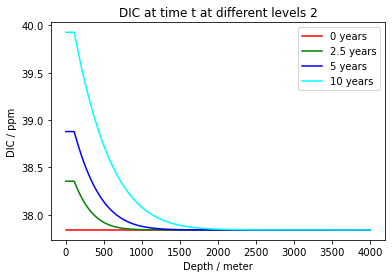

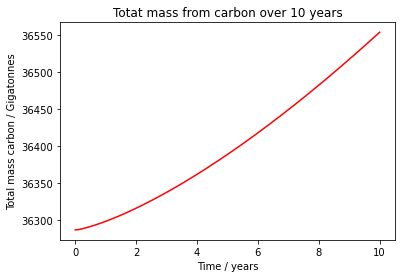

 Yearly antropic absorbsion in the ocean is: 2.6706759619201024e+16 per year


In [5]:
K0 = 10e-4#m^2/s
K1 = 10e-2#m^2/s
a = 0.5#m^-1
z0 = 100#meter
period = 365*10#days
z,dz = np.linspace(0,4000,N+1,retstep=True)
def K2(z):
    return K1 + (K0-K1)/(1+np.exp(-a*(z-z0)))

C_eq_val2 = 5060*415E-6 #mole/m^3
C_eq_vec2 = np.array([5060*(415E-6+2.3E-6*step*10/M) for step in range(M)]) #c0
IC2 = np.full((N+1),C_eq_val2)
results2,times2,maximum2,minimum2 = EulersStoreBror(C_eq_vec2,IC2,K2,period,z,dz)#antar ingen skuddår

plt.figure(2)
plt.title("DIC at time t at different levels 2")
plt.xlabel("Depth / meter")
plt.ylabel("DIC / ppm")
plt.plot(z,moleToPpm(results2[0]),"r",linestyle="-")
plt.plot(z,moleToPpm(results2[int(M/4)]),"g",linestyle="-")
plt.plot(z,moleToPpm(results2[int(M/2)]),"b",linestyle="-")
plt.plot(z,moleToPpm(results2[-1]),"aqua",linestyle="-")
plt.legend(("0 years","2.5 years","5 years","10 years"))
plt.show()

VolumeOcean = 360e12*4000 #overflate * avg_dybde som gitt i oppgaven
watermole = 1/(18.02E-6)*VolumeOcean
carbonmass = np.array([VolumeOcean*sum(results2[t]/(N+1))*12 for t in range(M)])

plt.figure(3)
plt.title("Totat mass from carbon over 10 years")
plt.xlabel("Time / years")
plt.ylabel("Total mass carbon / Gigatonnes")
plt.plot(times2/(3600*24*365),carbonmass*10**(-6-9),"r",linestyle="-")
plt.show()

print(f" Yearly antropic absorbsion in the ocean is: {(carbonmass[-1]-carbonmass[0])/10} per year")